<a href="https://colab.research.google.com/github/liamxdillon/ML_projects/blob/master/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!unzip "/content/drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "/content/drive/My Drive/Dog Vision/"

# End to End mutli class dog breed classification
## This notebook builds an end-to-end multi-class classifier using tensorflow 2.0 and tensorflow hub

## 1. Problem
Identifying the bread of a image of a dog

When im sitting at a cafe and i take a photo of a dog, i want to know that breed it is

## 2. Data
The data we are using is from Kaggle
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with predications probabilities for each dog breed of each test image

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features
Some information about the data :
* We are dealing with images (unstuctured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set. (Have labels)
* There are 10,000+ images in the test set (no lables, as want to predict)

# Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU


In [1]:
# Import TensorFlow into Colab
import tensorflow as tf
print ("TF version", tf.__version__)

import tensorflow_hub as hub
print ("TF Hub version", hub.__version__)

# Get for GPU available
print("GPU","available (Yesss!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version 2.3.0
TF Hub version 0.8.0
GPU available (Yesss!!!!)


## Getting our data ready and turn it in Tensors

With all machine learning models, our data needs to be in a numerical format, so thats what we'll be doing first, turning our images into Tensors (numerical representations)

Lets start by accessing our data and checking out the lables


In [2]:
# checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     ddde7d44c5c478092358387baee20cfb  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [3]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


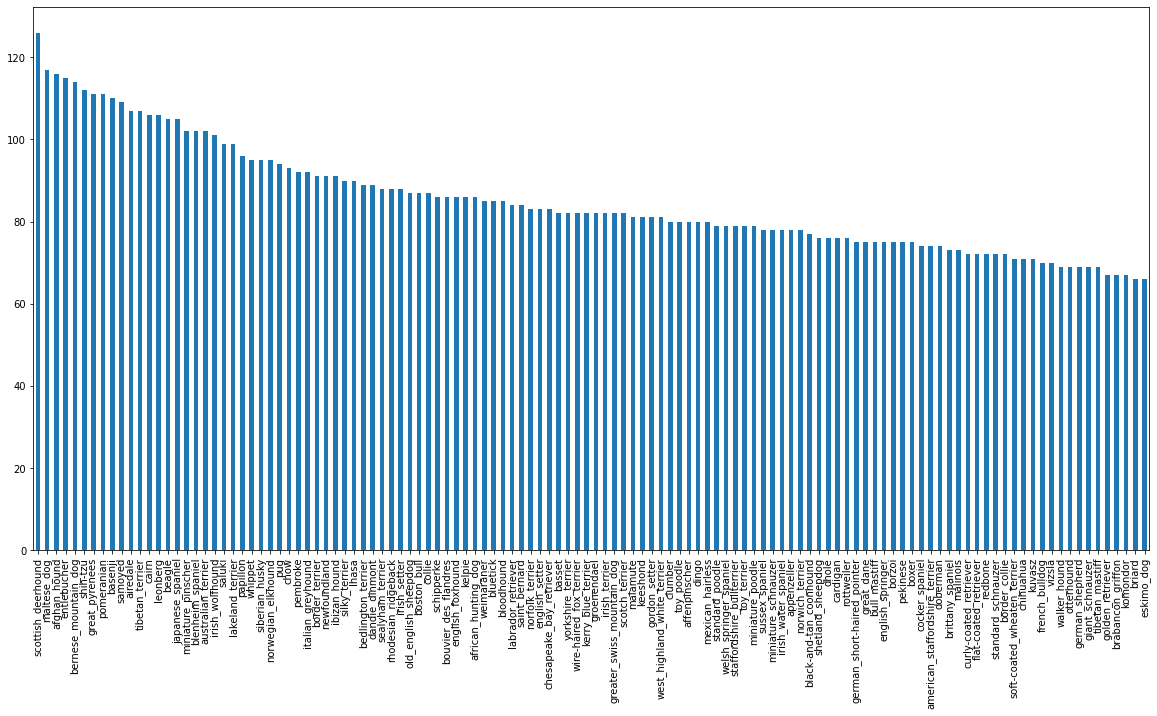

In [4]:
# How many images are there of each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [5]:
# whats the median sample of each breed
labels_csv["breed"].value_counts().median()

82.0

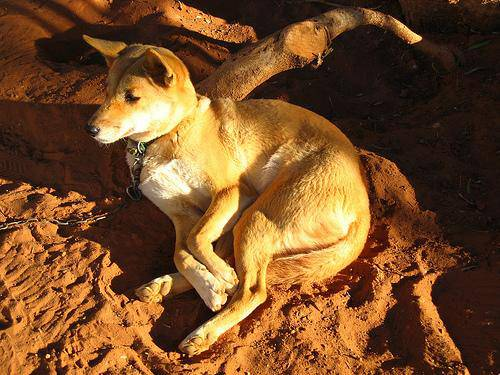

In [6]:
# Lets view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")
#Image("drive/My Drive/Dog Vision/train/ffd3f636f7f379c51ba3648a9ff8254f.jpg")


### Getting images and their labels
Lets get a list of all our images file path names

In [7]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
#Create path names from image IDs
filenames = ["drive/My Drive/Dog Vision/train/"+fname + ".jpg" for fname in labels_csv["id"]]

#check the first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [9]:
#check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files, proceed")
else:
  print("Filenames do not match actual amount of files, check the target directory")


Filenames match actual amount of files, proceed


In [ ]:
# one more check
#Image(filenames[9000])

In [ ]:
# Since we've now got our training image filepaths in a list, lets prepare our lables.

In [10]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [11]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of lables does not match the number filenames, check data directories")

Number of labels matches number of filenames


In [14]:
# Find the unique lable values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [15]:
# Turn a single label onto an arrary of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# Turn every label into a boolean array
#(loops around identifying which label equals an entry in the unique breeds)
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
#Example Turning boolean array into integres
print(labels[0]) # orgional label
print(np.where(unique_breeds == labels[0])) #index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) #there will be 1 where sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2]) # orgional label
print(boolean_labels[2].astype(int)) #there will be 1 where sample lable occurs

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we need to create our own.

In [17]:
X = filenames
y = boolean_labels

In [ ]:
#We are going to start off experimenting with ~1000 images and increas as needed

In [18]:
#Set number of images to use for eperimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [19]:
#Lets split our data into train and valudation sets.
from sklearn.model_selection import train_test_split

#Split them into traing and valudation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Lets have a look at the training data
X_train[:2], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, F

## Preprocessing images (turning images into Tensor)

To preprocess our images into Tensors, we are going to write a function which does a few things
1. Take image filepath as input
2. Use TensorFlow to read the file and save it to a variable 'image'
3. Turn our 'image' (a jpg into Tensors)
4. Resize the image to be a shape of (224, 244)
5. Return the modified image

Before we do, let's see what importing an image looks like

In [20]:
# convert image to a NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [21]:
image.max(), image.min() # image is made up of RGB values, max 255, min 0

(255, 0)

In [22]:
# convert it into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now that we've seen what an image looks like as a Tensor, lets make a function to prepocess them

To preprocess our images into Tensors, we are going to write a function which does a few things
1. Take image filepath as input
2. Use TensorFlow to read the file and save it to a variable 'image'
3. Turn our 'image' (a jpg into Tensors)
4. Normalise our image
5. Resize the image to be a shape of (224, 244)
6. Return the modified image

In [23]:
# Define image size
IMG_SIZE = 224

# Create a function for prepossing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turn the image into a Tensor
  """
  #Read in image file
  image = tf.io.read_file(image_path)
  #Turn the jpeg image into a numerical Tensor with 3 colour channels (red, green, blue)
  image = tf.image.decode_jpeg(image, channels=3)
  #Convert the colour channel value from 0-255 to valyes between 0-1 values  (normalisaton)
  image = tf.image.convert_image_dtype(image, tf.float32)
  #Resize the image to our desired value (224,224)
  image = tf.image.resize(image, size=[img_size, img_size])
  
  return image


## Turning our data into batches

Why turn our data into batches?

Lets say your trying to process 10,000+ images in one go, they might not all fit into memory
So thats why we do about 32 images (batch size) at a time. You can manual adjust batch size if need

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this :

'(image, label)'


In [24]:
# Create a simple function that returns a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and assocuated label,
  processing the image and returns a tuple of (image,label).
  """
  image = process_image(image_path)
  return image, label

In [25]:
#Demo of the above
(process_image(X[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tules of Tensors, in the form `(image, label)`, lets make a function to turn all of our data (X & y) into batches

In [26]:
#Define the batch size, 32 is a good start
BATCH_SIZE = 32

#Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data ouf if image (X) and label (y) pairs.
  Shuffles the data if it's training data, but doesn't shuffle if its validation data.
  Also accepts test data as input (no labels).
  """

  #If the data is a test data set, we probably dont have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only file paths no labels
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  # if the data is validation dataset, we dont need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                               tf.constant(y))) #labels
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                               tf.constant(y))) #labels
    #shuffing pathnames and labels before mapping image processor function its faster thean shuffling images
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    #Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  
  return data_batch

                                          
 

In [27]:
# Create training and validation databatches

train_data  = create_data_batches(X_train, y_train)
val_data =    create_data_batches(X_val, y_val, valid_data= True)

Creating training data batches...
Creating validation data batches...


In [28]:
# check out the different attributes of our data batches
# shape of 224x224, 120 unique labels
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [ ]:
#y[0]


## Visualizing data batches

Our date is now in batches, however these can be a little hard to understand/comprehend, lets visualize them.

In [29]:
import matplotlib.pyplot as plt
#create a function for viewing images in a data batch

def show_25_images(images,labels):
  """
  This displays a plot of 25 images and their labels in a data batch
  """
  #Set the figure
  plt.figure(figsize=(10,10))
  #Loop through 25 (for displaying 25 images)
  for i in range (25):
    #create subplots (5 rows, 5 columns)
    ax = plt.subplot(5,5,i+1)
    #display the image
    plt.imshow(images[i])
    #add the image lavel as the title
    plt.title(unique_breeds[labels[i].argmax()])
    #Turn the grid lines off
    plt.axis("off")
  

In [30]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [31]:
# this takes top batch off the stack
train_images, train_labels = next(train_data.as_numpy_iterator())

In [ ]:
#train_images, train_labels

# now lets visualise our data in a training batch

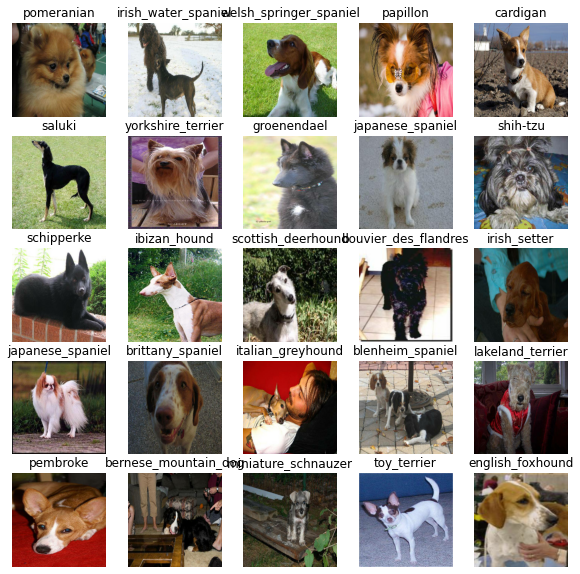

In [ ]:
show_25_images(train_images, train_labels)

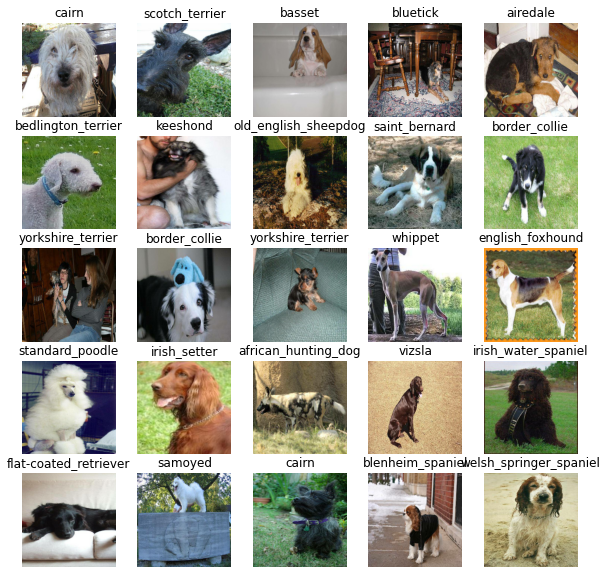

In [32]:
# Now lets visualise the our validation data
val_images, val_labels = next (val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)


## Building a model
before we build a model, there are a few things we need to define:
* The input shape (our image shape, in the form of Tensors) to our model.
* The output shapre (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub https://tfhub.dev/

In [33]:
# setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch height, witdth, colour channels

# Setup output shape of our model, i.e 1 or 120 unique breeds
OUTPUT_SHAPE = len(unique_breeds)

#Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


Now we got our inputs and output model ready to go, lets put them together into a Keras deep learning model
Knowing this, let's create a function which:
* Takes the input, output shape and the model we've chosen as prarameters.
* Define the layers in a Keras model in sequential fashion (do this first, then this, then that)
* Compiles the model (says it should be evaluated and improved)
* Builds the model (tells the model the input shape it will be getting)
* Returns the model

All of these steps can be found here https://www.tensorflow.org/overview

In [34]:
# create a function which builds a Keras model
def create_model(inout_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  #Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), #layer 1 (input_layer) aka MobileNet_v2
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, # override in this case to 120, one of the 120 unique dog classifications
                          activation="softmax") # layer 2 (output layer)
  ])
  #softmax,reformats so result is between 0 and 1

  #Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), #loss is a mesure of learning, loss of 0 would be perfert
      optimizer=tf.keras.optimizers.Adam(), #optimizer to help reduce the loss
      metrics=["accuracy"] #Judge of accuracy how well our model is correcting the correct image label.
  )
  #Build the model
  model.build(INPUT_SHAPE)

  return model



In [35]:
model = create_model()
model.summary()


Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [ ]:
#non trainable paramers are inheriented from MobileNet_V2 training (based on ImageNet)
# dense layer is trainable.


## Creating callbacks
Callbacks are helper functions a model can use during training to do such things as save its progress oe stop training if the model stops improving.

We'll create 2 callbacks, one for TensorBoard which helps track our models progress and the other for early stopping which prevents our model training for too long.

### TensorBoard Callback

To setup a TensorBoard Call back there are 3 things to do.
1. load the Tensorboard notebook extension
2. create a tensorboard callback which is able to save logs to a directory and pass it ro our mode's `fit()` funtion
3. Visualise our models trainings logs with the %tensorboard magic function (we'll do this after model training)


In [36]:
# Load TensorBoard notebook extension
%load_ext tensorboard


In [37]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  #create logs directory for storing TensorBoard logs
  logdir= os.path.join("/content/drive/My Drive/Dog Vision/logs",
                       #Make it so the logs get tracked whenever we run a experiment
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)


### Early Stopping Callback
 Early stopping stops our model overfiiting by stipping training if a certain evaulation metric stops  improving
 https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping




In [38]:
#create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)


## Traing a model (on a subset of data)
Our first mode is only going to train on 1000 images, to make sure everything is working


In [39]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100}

In [40]:
# Check to make sure we are still running on a GPU
print("GPU", "available!" if tf.config.list_physical_devices("GPU") else "not available :(")


GPU available!


Lets create a function which created a model
* Create a model using `create_model`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train (NUM_EPOCHS) and the callbacks we'd like to use
* Return the mode

In [41]:
#Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version
  """

  #create a model
  model = create_model()

  #Create a new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  #Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  #Return the fitted model
  return model

In [42]:
#Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
 1/25 [>.............................] - ETA: 0s - loss: 5.8255 - accuracy: 0.0000e+00WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


25/25 [==============================] - 647s 26s/step - loss: 4.5831 - accuracy: 0.0925 - val_loss: 3.2933 - val_accuracy: 0.2650
Epoch 2/100
25/25 [==============================] - 7s 279ms/step - loss: 1.6528 - accuracy: 0.6675 - val_loss: 2.0850 - val_accuracy: 0.5400
Epoch 3/100
25/25 [==============================] - 6s 259ms/step - loss: 0.5749 - accuracy: 0.9337 - val_loss: 1.6234 - val_accuracy: 0.6450
Epoch 4/100
25/25 [==============================] - 6s 258ms/step - loss: 0.2609 - accuracy: 0.9862 - val_loss: 1.4468 - val_accuracy: 0.6500
Epoch 5/100
25/25 [==============================] - 7s 286ms/step - loss: 0.1505 - accuracy: 0.9975 - val_loss: 1.3778 - val_accuracy: 0.6700
Epoch 6/100
25/25 [==============================] - 7s 275ms/step - loss: 0.1019 - accuracy: 1.0000 - val_loss: 1.3379 - val_accuracy: 0.6800
Epoch 7/100
25/25 [==============================] - 6s 259ms/step - loss: 0.0777 - accuracy: 1.0000 - val_loss: 1.3079 - val_accuracy: 0.6900
Epoch 8/100

** Question, looks like our model is overfitting because it's performed far better on the training dataset that the validation dateset, what are some ways to repvent model overfitting in deep learning neural networks?

** Note ** overfitting to begin with is a good thing, it means our model is learning!!!

### Checking the tensorBoard logs
The TensorBoard magic function (`%tensorboard`) will access the logs directory we created ealier and visualise its content

In [43]:
%tensorboard --logdir /content/drive/My\ Drive/Dog\ Vision/logs

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model

In [44]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 175ms/step


array([[8.9322729e-04, 2.4423280e-04, 1.2236029e-03, ..., 5.2982633e-04,
        7.9828344e-05, 1.9219186e-03],
       [6.4351747e-04, 1.5327292e-03, 8.3095878e-02, ..., 2.0826445e-04,
        3.1595436e-04, 5.0332543e-04],
       [7.6327569e-07, 4.0506347e-05, 7.6355966e-05, ..., 3.5915156e-05,
        1.5028329e-05, 1.7860868e-05],
       ...,
       [3.0421641e-06, 3.7249796e-05, 3.9780793e-05, ..., 2.5279796e-05,
        3.0322291e-04, 4.2785821e-05],
       [2.4611703e-03, 5.4012117e-04, 7.1363477e-04, ..., 4.1163655e-04,
        3.7787133e-05, 1.9760972e-02],
       [4.2271774e-04, 1.7200691e-05, 1.9209760e-03, ..., 8.3639176e-04,
        8.0131320e-04, 2.9332883e-04]], dtype=float32)

In [45]:
predictions.shape

(200, 120)

In [46]:
len(y_val)

200

In [47]:
len(unique_breeds)

120

In [48]:
# First prediction
index = 0
print(predictions[index])
print(f"Max Value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum:{np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[8.93227290e-04 2.44232797e-04 1.22360291e-03 4.13324124e-05
 4.86014033e-04 3.73399380e-05 5.17716119e-03 1.68025232e-04
 3.73809125e-05 2.80339341e-03 5.13443083e-04 5.18840796e-04
 6.92139438e-05 4.45551086e-05 3.66896566e-04 1.84597084e-04
 1.19624514e-04 1.72751769e-01 6.66721171e-05 5.42332637e-05
 2.48913217e-04 1.16606112e-04 4.28656422e-05 8.09740741e-04
 3.77127035e-05 3.46739689e-04 2.62503445e-01 5.43056158e-05
 1.75465073e-04 5.64985618e-04 1.40748270e-05 4.78116469e-03
 1.15457946e-03 1.92206953e-05 1.74911824e-04 4.74267732e-03
 1.91434065e-05 1.79166163e-04 2.09222999e-04 1.33307221e-05
 3.05163092e-04 6.69808287e-05 1.46308375e-04 9.97169409e-04
 1.21420217e-05 2.80828099e-04 3.12168995e-05 1.93310596e-04
 1.79782932e-04 1.50935433e-04 2.96640301e-05 4.97326982e-05
 8.61196662e-04 1.06991683e-04 2.75333237e-04 3.29188042e-05
 2.68778731e-05 8.32318561e-04 5.24117379e-04 1.52609289e-01
 1.11499324e-03 2.43842063e-04 1.20053429e-03 3.74319970e-05
 6.72603317e-04 6.130545

Having the above functionality is great, but we want to be able to do it at scale, and it would be even better if we could see the image of the prediction is being made on.

** note ** prediction probabilities are also known as confidence levels

In [49]:
# Turn  predictions probabilities into the respective label (eaier to understand)
def get_pred_label (prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)] 
  #np.argmax(prediction_probabilities) returns index

#Get a predicted label baed on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label


'dingo'

In [50]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

Now since our validation data is still in a batch dataset, we have to unbatchify it to make predictions on the valudation images and then compare those predictions to the validation labels (truth labels)

In [51]:
#create a function to unbatch a batch dataset

def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
  """
  images = []
  labels = []

  #loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

#Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* prediction labels
* validation lables (truth labels)
* validation images
Let's make some functions to make thesea bit more visual

We'll create a function which:
* Takes an array of prediction probabilites, and array of truth labels and an array of images and intergers
* Convert the preduction probabilities to a predicted label
* Plot the preducted label, its predicted probability, the truth label and the target image on a single plot.


In [52]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  #Get the pred label
  pred_label = get_pred_label(pred_prob)

  #Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  #Change the colour of the title if the prediction is right or wrong

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  #change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:3.0f}% {}".format(pred_label,
                                     np.max(pred_prob)*100,
                                      true_label),
                                      color=color)
  


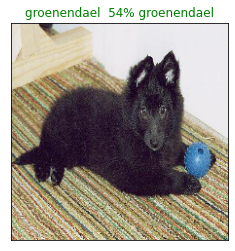

In [53]:
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=77)
  

Now we've got 1 funtion to visualise or models top predictions, lets make another to make models top 10 prediction.

This function will:
* Take an input of preduction probabilities array abd a ground truth array and an integer
* Find the prediction using `get_pred_labels()`
* Find the top 10
  * prediction probabilites index
  * prediction probabilites value
  * prediction labels
* Plot the top 10 prediction probability values and labels, coluring the the true label green


In [54]:
def plot_pred_conf(prediction_probabilities, labels, n= 1):
  """
  Plus the top 10 highest prediction confidences along with the thuth label for sample n
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  #get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1] # -1 reverse
  # Find top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup a plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                    top_10_pred_values, 
                    color="grey")

  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  

  #Change colour of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass


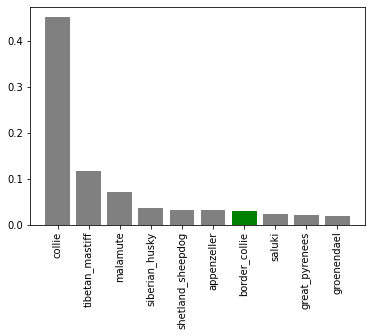

In [55]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

#1st on left is predicted value, one highlighted in green is the true label

Now we've got some functions to help us visualise our predictions, lets check out a few.


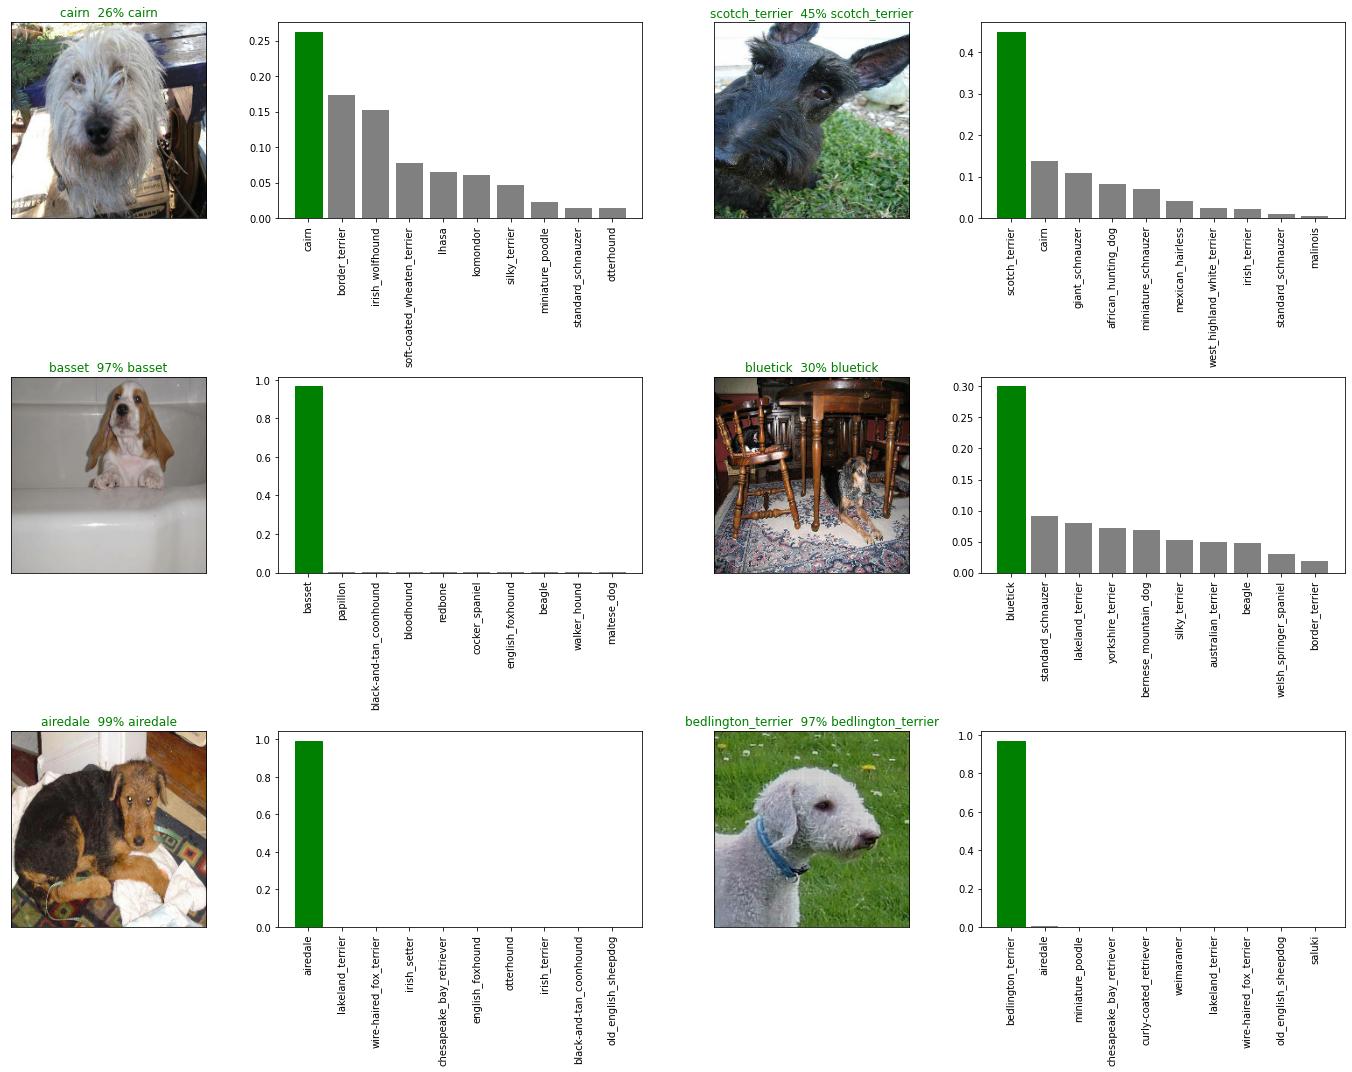

In [56]:
# Lets check out a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  
  plt.subplot(num_rows, 2*num_cols, 2*i+2)

  plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=i+i_multiplier)
  
  plt.tight_layout(h_pad=1.0)

plt.show()


## Saving and reloading a trained model

In [57]:
# Create a function to save a model
def save_model (model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix(string)
  """
  #Create a model directory pathname with current time
  modeldir = os.path.join("/content/drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path



In [58]:
# Create a function to load a model
def load_model (model_path):
  """
  Load a saved model from a specified path. 
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model


Now we've got functions to save and load a trained model, lets make sure they work

In [59]:
#Save our model, trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")


Saving model to: /content/drive/My Drive/Dog Vision/models/20200806-162150-1000-images-mobilenetv2-Adam.h5...


'/content/drive/My Drive/Dog Vision/models/20200806-162150-1000-images-mobilenetv2-Adam.h5'

In [60]:
#Load a trained model
loaded_1000_image_model = load_model('/content/drive/My Drive/Dog Vision/models/20200701-134503-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: /content/drive/My Drive/Dog Vision/models/20200701-134503-1000-images-mobilenetv2-Adam.h5


In [61]:
# Evaluate the pre-saved model
model.evaluate(val_data)


7/7 [==============================] - 1s 146ms/step - loss: 1.2365 - accuracy: 0.7100


[1.236473798751831, 0.7099999785423279]

In [62]:
#Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 160ms/step - loss: 1.2501 - accuracy: 0.6800


[1.2500810623168945, 0.6800000071525574]

# Training a big dog model on the full data


In [63]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)


Creating training data batches...


In [64]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [65]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [66]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

#no valudation set when training on all the data, so we can't monitor the validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)


** Note *** Running the cell below will take a little time (around 30 mins for 1st epoch) because the GPU we're using in in the runtime has to load all the images into memory


In [ ]:
#Fit the full model to the full data
full_model.fit(x=full_data, 
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])


Epoch 1/100
320/320 [==============================] - 6400s 20s/step - loss: 1.3399 - accuracy: 0.6707
Epoch 2/100
320/320 [==============================] - 64s 200ms/step - loss: 0.4016 - accuracy: 0.8808
Epoch 3/100
320/320 [==============================] - 62s 194ms/step - loss: 0.2399 - accuracy: 0.9345
Epoch 4/100
320/320 [==============================] - 64s 200ms/step - loss: 0.1559 - accuracy: 0.9620
Epoch 5/100
320/320 [==============================] - 65s 202ms/step - loss: 0.1082 - accuracy: 0.9794
Epoch 6/100
320/320 [==============================] - 63s 198ms/step - loss: 0.0771 - accuracy: 0.9876
Epoch 7/100
320/320 [==============================] - 64s 199ms/step - loss: 0.0589 - accuracy: 0.9916
Epoch 8/100
320/320 [==============================] - 62s 194ms/step - loss: 0.0455 - accuracy: 0.9945
Epoch 9/100
320/320 [==============================] - 63s 196ms/step - loss: 0.0376 - accuracy: 0.9962
Epoch 10/100
320/320 [==============================] - 61s 192m

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: /content/drive/My Drive/Dog Vision/models/20200702-115157-full-image-set-mobilenetv2-Adam.h5...


'/content/drive/My Drive/Dog Vision/models/20200702-115157-full-image-set-mobilenetv2-Adam.h5'

## ===== Resinstalling some functions etc to avoid re-loading whole workbook =====

In [1]:
# Import TensorFlow into Colab
import tensorflow as tf
print ("TF version", tf.__version__)

import tensorflow_hub as hub
print ("TF Hub version", hub.__version__)

# Get for GPU available
print("GPU","available (Yesss!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

import os
import numpy as np

TF version 2.3.0
TF Hub version 0.8.0
GPU available (Yesss!!!!)


In [2]:
# Create a function to load a model
def load_model (model_path):
  """
  Load a saved model from a specified path. 
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [3]:
# Load the full model
loaded_full_model = load_model('/content/drive/My Drive/Dog Vision/models/20200701-155816-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: /content/drive/My Drive/Dog Vision/models/20200701-155816-full-image-set-mobilenetv2-Adam.h5


In [4]:
# Define image size
IMG_SIZE = 224

# Create a function for prepossing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turn the image into a Tensor
  """
  #Read in image file
  image = tf.io.read_file(image_path)
  #Turn the jpeg image into a numerical Tensor with 3 colour channels (red, green, blue)
  image = tf.image.decode_jpeg(image, channels=3)
  #Convert the colour channel value from 0-255 to valyes between 0-1 values  (normalisaton)
  image = tf.image.convert_image_dtype(image, tf.float32)
  #Resize the image to our desired value (224,224)
  image = tf.image.resize(image, size=[img_size, img_size])
  
  return image

In [5]:
#Define the batch size, 32 is a good start
BATCH_SIZE = 32

#Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data ouf if image (X) and label (y) pairs.
  Shuffles the data if it's training data, but doesn't shuffle if its validation data.
  Also accepts test data as input (no labels).
  """

  #If the data is a test data set, we probably dont have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only file paths no labels
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  # if the data is validation dataset, we dont need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                               tf.constant(y))) #labels
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                               tf.constant(y))) #labels
    #shuffing pathnames and labels before mapping image processor function its faster thean shuffling images
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    #Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  
  return data_batch

In [6]:
# Create a function to save a model
def save_model (model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix(string)
  """
  #Create a model directory pathname with current time
  modeldir = os.path.join("/content/drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [28]:
# Turn  predictions probabilities into the respective label (eaier to understand)
def get_pred_label (prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)] 
  #np.argmax(prediction_probabilities) returns index

#Get a predicted label baed on an array of prediction probabilities
#pred_label = get_pred_label(predictions[81])
#pred_label


## =====End of function reload=====

## Making predictions on the test dataset

Since our model has been trained in the form of Tensor batches, to make prediction we need the test data in the same shape

Luckily we created create_data_batches ealier and convert them into Tensor batches
To make predictions on the test data we'll:
* Get test image file names
* Convert the filenames into test data batches using create_data_batches and setting the `test_data` parameters to`True` since the test data doesn not have labels
* Make a predictions array by passing the test batch to`predict method called in our model

In [8]:
# load test image filenames
test_path = "/content/drive/My Drive/Dog Vision/test/"
test_filenames = [test_path +fname for fname in os.listdir(test_path)]
test_filenames[:10]


['/content/drive/My Drive/Dog Vision/test/e864f3fc5d19aec4b7a5aa547b359c57.jpg',
 '/content/drive/My Drive/Dog Vision/test/f2b7d11ea6ccf65f214cac2abee8d1a1.jpg',
 '/content/drive/My Drive/Dog Vision/test/f0e6e1a934316bb94a6a1eeba894e32e.jpg',
 '/content/drive/My Drive/Dog Vision/test/f35c272e3ece87df743552aa517488b0.jpg',
 '/content/drive/My Drive/Dog Vision/test/edf164f8974510c5936ee7224f3d7d56.jpg',
 '/content/drive/My Drive/Dog Vision/test/f33c435b1e92d5a639e6fc9463821595.jpg',
 '/content/drive/My Drive/Dog Vision/test/ee59d7c0fdd2344e9d6d815f1099ffb1.jpg',
 '/content/drive/My Drive/Dog Vision/test/f1dcabbeb1dbebb326a4b029b6f8b188.jpg',
 '/content/drive/My Drive/Dog Vision/test/ed306448d7f19d3e5cfd7b446898cd44.jpg',
 '/content/drive/My Drive/Dog Vision/test/efa05bbbd2e169dc723df1a43ff0e1bb.jpg']

In [74]:
len(test_filenames)

10357

In [9]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)


Creating test data batches...


In [10]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>


*** Note *** calling predict () on our full model and passing it the test data batch will take a long time to run ( about 1 hour)

In [11]:
# Make predictions on test data batch using the loaded full model
# 324 runs of 32 batches each ~=10357
test_predictions = loaded_full_model.predict(test_data, 
                                             verbose=1)

324/324 [==============================] - 6634s 20s/step


In [12]:
# Save predictions (NumPy array) to csv for access later
np.savetxt("/content/drive/My Drive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")


In [13]:
# Load predictions (NumPy array from csv file)
test_predictions = np.loadtxt("/content/drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")


In [14]:
test_predictions[:10]


array([[2.00417773e-07, 4.86955059e-07, 1.92569346e-11, ...,
        1.03538751e-08, 1.25703692e-11, 2.03791914e-10],
       [7.08289538e-11, 8.38833980e-09, 1.19587090e-10, ...,
        4.18469126e-09, 1.06051189e-10, 1.15216107e-10],
       [1.23442289e-11, 2.95934853e-13, 1.96397301e-13, ...,
        3.28512208e-14, 1.27198046e-12, 5.19078920e-13],
       ...,
       [2.06948525e-09, 3.31705802e-10, 5.54180923e-10, ...,
        3.24325840e-04, 1.27125432e-07, 2.08243023e-08],
       [1.24882271e-09, 2.90135485e-11, 4.72883295e-11, ...,
        6.41300034e-12, 1.07196425e-10, 6.54373444e-10],
       [1.25962627e-08, 1.86468831e-08, 5.13856735e-10, ...,
        3.11649337e-08, 9.52793400e-08, 2.17631282e-06]])

In [15]:
test_predictions.shape

(10357, 120)

## Prepare test dataset prediction for Kaggle

Looking at the Kaggle sample submission, we find it wants our model prediction output in a dataframe with a coloumn with an ID and a solumn for each dog breed.

To get the data in this format, we'll:
* create a pandas a DataFrame with an ID column as well as acolumn for each dog breed
* Add data to the ID colum by extracting the test image IDs from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns
* Export the DataFrame as a .csv file to submit it to Kaggle


In [16]:
# reload these so dont have to reload whole workbook
import pandas as pd
import numpy as np
labels_csv = pd.read_csv("/content/drive/My Drive/Dog Vision/labels.csv")
labels = labels_csv["breed"]
labels = np.array(labels)

# Find the unique lable values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [17]:
# load test image filenames
test_path = "/content/drive/My Drive/Dog Vision/test/"
test_filenames = [test_path +fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/My Drive/Dog Vision/test/e864f3fc5d19aec4b7a5aa547b359c57.jpg',
 '/content/drive/My Drive/Dog Vision/test/f2b7d11ea6ccf65f214cac2abee8d1a1.jpg',
 '/content/drive/My Drive/Dog Vision/test/f0e6e1a934316bb94a6a1eeba894e32e.jpg',
 '/content/drive/My Drive/Dog Vision/test/f35c272e3ece87df743552aa517488b0.jpg',
 '/content/drive/My Drive/Dog Vision/test/edf164f8974510c5936ee7224f3d7d56.jpg',
 '/content/drive/My Drive/Dog Vision/test/f33c435b1e92d5a639e6fc9463821595.jpg',
 '/content/drive/My Drive/Dog Vision/test/ee59d7c0fdd2344e9d6d815f1099ffb1.jpg',
 '/content/drive/My Drive/Dog Vision/test/f1dcabbeb1dbebb326a4b029b6f8b188.jpg',
 '/content/drive/My Drive/Dog Vision/test/ed306448d7f19d3e5cfd7b446898cd44.jpg',
 '/content/drive/My Drive/Dog Vision/test/efa05bbbd2e169dc723df1a43ff0e1bb.jpg']

In [18]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [ ]:
#test_filenames

In [19]:
#Append test image ID's to the prediction DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
#test_ids[:10]

preds_df["id"] = test_ids
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e864f3fc5d19aec4b7a5aa547b359c57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f2b7d11ea6ccf65f214cac2abee8d1a1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f0e6e1a934316bb94a6a1eeba894e32e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f35c272e3ece87df743552aa517488b0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,edf164f8974510c5936ee7224f3d7d56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#os.path.splitext(test_filenames[0])

In [20]:
# Add the prediction probabilitie to each dog breeed columns
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e864f3fc5d19aec4b7a5aa547b359c57,2.00418e-07,4.86955e-07,1.92569e-11,3.64757e-09,6.33672e-11,1.6047e-11,2.18527e-09,9.55363e-10,1.97808e-11,7.72213e-13,1.39054e-07,1.72316e-10,1.94572e-09,9.45131e-08,2.76182e-10,5.20211e-11,1.05902e-10,9.11661e-11,1.25709e-10,5.41236e-09,2.67588e-07,5.94495e-11,1.27714e-08,1.05246e-08,1.1747e-09,1.8293e-10,1.77922e-09,5.80178e-10,1.96988e-09,4.51178e-13,1.17163e-08,3.02535e-08,1.68967e-08,8.2371e-11,3.8948e-11,1.79243e-10,1.28221e-10,5.11112e-10,1.08883e-10,...,2.15782e-08,6.02624e-08,3.65244e-07,6.22149e-06,4.2702e-11,5.3614e-10,5.96265e-13,3.73843e-10,1.12023e-09,3.13108e-08,5.42388e-09,2.65665e-11,2.55899e-11,1.7715e-09,5.26388e-09,2.61926e-09,3.21757e-11,3.60078e-07,3.9575e-10,2.76512e-11,2.36072e-10,3.5335e-09,3.20126e-11,7.16386e-08,1.32807e-11,2.43187e-06,5.88242e-07,3.10908e-08,4.11513e-08,9.31417e-05,1.75932e-08,5.44596e-12,1.04157e-12,3.9592e-09,1.30002e-09,6.63208e-09,2.71411e-12,1.03539e-08,1.25704e-11,2.03792e-10
1,f2b7d11ea6ccf65f214cac2abee8d1a1,7.0829e-11,8.38834e-09,1.19587e-10,4.60142e-07,6.5942e-08,0.0012096,2.44432e-09,2.33098e-09,2.98055e-08,1.81245e-08,1.79668e-08,0.996319,6.77375e-08,2.19224e-07,4.74904e-09,2.06235e-07,4.73552e-06,2.4542e-10,2.47023e-09,3.58491e-07,3.17998e-09,1.18028e-11,9.54565e-11,7.92413e-09,1.05698e-06,1.30743e-08,7.04588e-10,4.41789e-09,4.11835e-08,6.76525e-08,3.19573e-09,1.00319e-07,1.06465e-08,9.97157e-06,1.45496e-09,1.9524e-09,3.92571e-09,2.54149e-11,2.11578e-07,...,2.6293e-10,9.91698e-10,4.59719e-06,2.06984e-07,8.57042e-10,5.87453e-08,4.06752e-08,1.67575e-09,1.04452e-10,4.20286e-09,2.34562e-10,5.72321e-09,3.93301e-06,1.5166e-07,1.67312e-08,2.27034e-08,9.34202e-11,5.3682e-08,6.8295e-12,3.97969e-05,1.23267e-09,1.40715e-09,2.01029e-08,6.25353e-10,1.47644e-09,2.8005e-08,1.159e-10,7.75458e-07,1.91626e-06,1.50413e-06,6.6924e-09,5.51899e-12,1.0241e-08,1.54587e-06,3.36038e-09,5.8853e-07,2.15635e-08,4.18469e-09,1.06051e-10,1.15216e-10
2,f0e6e1a934316bb94a6a1eeba894e32e,1.23442e-11,2.95935e-13,1.96397e-13,6.15092e-10,4.02874e-09,8.6067e-12,6.4935e-11,5.92306e-13,7.3442e-12,2.49328e-08,4.53145e-10,1.55283e-12,3.22041e-10,1.44917e-11,4.27168e-10,4.34178e-11,6.51608e-12,1.15299e-10,3.45491e-12,4.16286e-10,3.60684e-11,6.11328e-10,4.0115e-14,1.08884e-13,2.57628e-06,8.0499e-10,1.7528e-13,1.70147e-13,0.999595,1.38348e-10,1.59715e-12,7.38436e-11,4.08978e-13,1.95077e-09,0.000276783,1.55613e-11,3.55727e-09,4.1203e-10,1.91149e-10,...,1.5004e-09,4.94665e-13,2.91433e-10,2.66148e-10,2.42644e-13,4.63531e-12,4.97881e-13,1.70191e-13,1.50893e-10,1.73191e-07,2.24277e-10,1.15039e-10,3.91868e-11,7.66676e-14,3.39584e-13,5.69933e-10,2.10515e-11,7.85233e-10,1.03573e-11,2.82307e-13,6.3036e-11,4.99825e-11,1.76313e-11,4.96663e-12,8.14845e-08,2.32721e-07,1.18722e-13,6.4638e-08,1.66885e-13,2.90495e-12,3.35977e-12,3.76596e-13,5.32591e-07,1.5428e-08,4.88493e-09,6.29334e-12,9.78867e-11,3.28512e-1

In [21]:
# export dataframe to csv
preds_df.to_csv("/content/drive/My Drive/Dog Vision/full_model_prediction_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images
To make predictions on custom images, we'll:
* Get the file filepaths of our own images
* Turn the filepaths into data batches using `create_data_bathces()`. Since our custom images wont have labels , we set the `test_data` paramters to `True`
* Pass the custom image data batch to our models predict() method
* Convert the predictions ouput probabilities to predictions labels
* Compare the predicted labels to the custom images.

In [22]:
# Get the custom image filepath
custom_path = "/content/drive/My Drive/Dog Vision/my_dog_photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [23]:
custom_image_paths

['/content/drive/My Drive/Dog Vision/my_dog_photos/dog_german_shepherd_dog_other.jpg',
 '/content/drive/My Drive/Dog Vision/my_dog_photos/dog2.jpg',
 '/content/drive/My Drive/Dog Vision/my_dog_photos/dog-4372036__340.jpg']

In [24]:
# turn custom images into btch dataset
custom_data = create_data_batches(custom_image_paths, test_data= True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [25]:
#Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)
custom_preds.shape

(3, 120)

In [29]:
#Get custom imagae image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range (len(custom_preds))]
custom_pred_labels

['german_shepherd', 'siberian_husky', 'golden_retriever']

In [30]:
#Get custom images (our unbatcjify() function wont work since there aren't any labels , maybe we could fit this later)
custom_images = []
#Loop through unbatches data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)


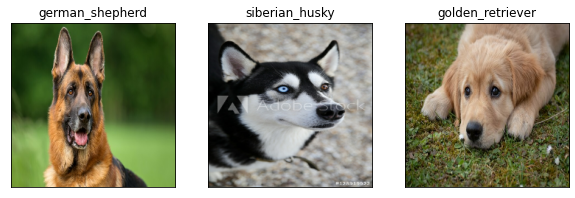

In [34]:
#check custom image predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)
